# Assignment im Kurs Machine Learning Fundamentals

### Projekt Teilnehmer
* Anna Stöhrer da Silva
* Bernice Fabich
* Jan Schneeberg
* Niklas Elsässer

### Dozent
* Ruben Nuredini

## Abstract
Im Rahmen der vorliegenden Untersuchung wird die Leistungsfähigkeit der Latent Dirichlet Allocation Method (LDA) anhand eines umfangreichen News-Category-Datasets evaluiert. Dabei wird die reguläre LDA-Methode mit einem verbesserten Ansatz, LDAPrototype genannt, verglichen.

# Inhaltsverzeichnis
- [Theoretische Grundlagen](#theoretische-grundlagen)
- [Datenvorbereitung](#Datenvorbereitung)
- [LDA Modell](#step-4-das-lda-model-trainieren)
- [PyLDAvis](#step-4-visualisierung-mit-pyldavis)
- [Improved LDA](https://github.com/NiklasElsaesser/bug-free-fishstick/blob/main/Improved_LDA.ipynb) (Separates Notebook)
- [Benchmarks & Visualizations](https://github.com/NiklasElsaesser/bug-free-fishstick/blob/main/Benchmarks%26Visualizations.ipynb) (Separates Notebook)
- [Literaturverzeichnis](#literaturverzeichnis)

# Theoretische Grundlagen
Durch die Digitalisierung stieg die Anzahl von digitalen Texten drastisch an und steigt immer noch an, sodass diese kaum noch zu fassen sind. So umfasst das Deutsche Textarchiv (digitale Textsammlung) um die 145 Millionen Texte.
Diese Masse an Texten muss verwaltet werden, sodass Texte gefunden und abgebildet werden können. Des Weiteren müssen sie mit Unterstützung von Computern ausgewertet werden können, da dies manuell kaum machbar wäre.
Im Jahr 2007 beschäftigte sich Franco Moretti innerhalb seines Forschungsprogramms damit, tausend Werke der Weltliteratur gleichzeitig miteinander zu vergleichen. Möglich war dies aber nur mithilfe von (text-) statischen Verfahren und mit computergestützten Visualisierungen. (Heyer, Wiedemann, Niekler 2020, S.351-353)

## Topic Modeling
Topic Modelling ist eine bekannte Klasse dieser statischen Verfahren. Hierbei können große Datenmengen/Textmengen automatisch in Themenbereiche aufgeteilt werden. Es wird davon ausgegangen, dass jede Wortform zu einem Themenbereich (Topic) gehört. Durch die Untersuchung der Verteilung von zusammengehörigen Wortformen in einem Text sollen die Themenbereiche dieses Textes abgeleitet werden können.
Hiermit ist das Klassifizieren und Zusammenfassen von Texten und deren Abschnitten möglich. (Heyer, Wiedemann, Niekler 2020, S.351-353)

## Stärken und Schwächen
Stärken sind demnach die Unterteilung in Themen von großen Texten.
Eine Stärke ist ebenfalls die Tatsache, dass dies voll automatisch geschieht.
Nachteil ist, dass Syntax-Strukturen, Regelmäßigkeiten der Aussagen und weitere Informationen nicht aus dem Topic Modelling resultieren.
Dennoch kann Topic Modelling als Vorarbeit für die weitergehenden Untersuchungen genutzt werden. (Heyer, Wiedemann, Niekler 2020, S.351-353)


# Step 0: Libraries importieren

In [118]:
# The Basics
import pandas as pd
import numpy
from pprint import pprint

In [119]:
# The Preprocessing
import re
import nltk
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import re

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/niklaselsasser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [120]:
# The Modell
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models.ldamodel import LdaModel

# Step 1: Das Dataframe (be)laden

In [121]:
#code necessary when running in colab
#from google.colab import drive
#drive.mount('/content/drive')

In [122]:
#code necessary when running in colab
import json
import pandas as pd

dataset_path = "News_Category_Dataset_v3.json"

with open(dataset_path, 'r') as file:
    news_data = [json.loads(line) for line in file]

df = pd.DataFrame(news_data)

In [123]:
#code necessary when running locally
df = pd.read_json("News_Category_Dataset_v3.json", lines=True)

# Step 2: Data Cleansing

In [124]:
df.drop(columns=["link", "authors", "date"], inplace=True)
df.head()

,headline,category,short_description
0,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...
1,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...
2,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha..."
3,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to..."
4,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...


Auf den ersten Blick können wir erkennen, dass die Kategorie "U.S. NEWS" eher ein mix aus unterschiedlichen Themen ist.
<br>Das könnte später unseren Algorithmus verwirren, weshalb wir Kategorien welche aus unterschiedlichen Themen bestehen, entfernen wollen.

In [125]:
df.category.unique()

array(['U.S. NEWS', 'COMEDY', 'PARENTING', 'WORLD NEWS', 'CULTURE & ARTS',
       'TECH', 'SPORTS', 'ENTERTAINMENT', 'POLITICS', 'WEIRD NEWS',
       'ENVIRONMENT', 'EDUCATION', 'CRIME', 'SCIENCE', 'WELLNESS',
       'BUSINESS', 'STYLE & BEAUTY', 'FOOD & DRINK', 'MEDIA',
       'QUEER VOICES', 'HOME & LIVING', 'WOMEN', 'BLACK VOICES', 'TRAVEL',
       'MONEY', 'RELIGION', 'LATINO VOICES', 'IMPACT', 'WEDDINGS',
       'COLLEGE', 'PARENTS', 'ARTS & CULTURE', 'STYLE', 'GREEN', 'TASTE',
       'HEALTHY LIVING', 'THE WORLDPOST', 'GOOD NEWS', 'WORLDPOST',
       'FIFTY', 'ARTS', 'DIVORCE'], dtype=object)

Kategorien welche wahrscheinlich mehrere Themen umfassen werden erfasst. Im unteren Sample können wir erkennen, dass unsere These korrekt ist.

In [126]:
df[df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])].sample(5, random_state=0)

,headline,category,short_description
4996,93-Year-Old Woman Goes Viral When She Tells In...,WEIRD NEWS,"On Monday, Coors Light dropped off 150 cans of..."
6399,Shooting At Brooklyn Community Event Leaves 1 ...,U.S. NEWS,New York City Mayor Bill de Blasio vowed to “d...
74496,Woman Accused Of Commandeering Bus After Drive...,WEIRD NEWS,She didn't get very far.
24611,Now I Know What Fear Is,WORLD NEWS,"Everywhere I looked on my way home, someone wa..."
127331,Reinventing Europe Along These 7 Points,WORLDPOST,"In its present form, the EU is weak, particula..."


Was auch ins Auge fällt, ist Zeile `74496`. Ihre short_description ist zu kurz um daraus einen wertvollen Einblick zu erhalten. Das merken wir uns für später ;)

In [127]:
# Removal of useless categories
df = df[~df["category"].isin(["U.S. NEWS", "WORLD NEWS", "WEIRD NEWS", "THE WORLDPOST", "WORLDPOST"])]

In [128]:
unique_categories = len(df.category.unique())
print(f"{unique_categories=}")

unique_categories=37


Wir haben die alten Kategorien entfernt und sind jetzt bei schlanken 37 Kategorien.
<br>Als nächstes bereiten wir den Text aus der Überschrift und der Beschreibung etwas auf.
<br>Dazu entfernen wir alle Interpunktierung, Stoppwörter, Sonderzeichen und sorgen dafür, dass alle Buchstaben klein geschrieben sind.

In [129]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)

    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

Ein Beispiel wie diese Textaufbereitung funktiniert und was sie zurückgibt, findet sich in der unteren Zelle

In [130]:
print(preprocess_text("This is a very important text mentioning the President, the Health Department and Germany"), sep=" ")

['important', 'text', 'mentioning', 'president', 'health', 'department', 'germany']


In [131]:
# Apply preprocessing to the headlines and short descriptions
df['processed_text'] = df.apply(lambda row: preprocess_text(row['headline'] + ' ' + row['short_description']), axis=1)

# Filter out empty processed_text
processed_df = df[df['processed_text'].apply(len) > 0]

# Inspect the processed text
print(processed_df[['category', 'processed_text']].head())

          category                                     processed_text
2           COMEDY  [23, funniest, tweet, cat, dog, week, sept, 17...
3        PARENTING  [funniest, tweet, parent, week, sept, 1723, ac...
8   CULTURE & ARTS  [new, documentary, capture, complexity, child,...
13            TECH  [twitch, ban, gambling, site, streamer, scam, ...
16  CULTURE & ARTS  [reboot, clever, navelgazey, look, inside, tv,...


In [132]:
# Overview over preprocessed text
processed_df[['short_description', 'processed_text']].sample(5)

,short_description,processed_text
8958,"His words, reportedly uttered in private, have...","[gay, man, say, pope, francis, told, god, made..."
10648,"""Not all women are under legally binding agree...","[stephen, colbert, repeat, fun, fact, woman, d..."
116277,,"[huffpost, hill, cant, retake, senate, harry, ..."
5645,Myanmar's Swe Zin Htet says she hopes to push ...,"[meet, miss, universe, pageant, first, openly,..."
149357,For those who think of Nantucket as the kingdo...,"[nantucket, full, surprise, think, nantucket, ..."


In [133]:
# Extract just the processed texts for future use
processed_texts = [doc["processed_text"] for _, doc in processed_df.iterrows()] 

# Step 3: Hilfsmittel für das LDA Model erstellen
Um das LDA Model später geordnet zu erzeugen, erstellen wir zwei Hilfsmittel.
### Dictionary: ID zu Wort
Corpora weißt jeden Wort eine eindeutige ID zu, mit welcher es später wieder erkannt werden kann.
<br>Dies hilft bei der schnellen und effizienten Verarbeitung der Wörter

### Liste: Korpus
Der Korpus listet für alle Dokumente einen Vektor welchen wir als "Bag of Words" bezeichnen.
<br>Er enthält alle Wörter und ihre Häufigkeit in dem Dokument. Über diesen Vektor, kann dem Dokument eine Bedeutung zugewiesen werden.

In [134]:
id2word = corpora.Dictionary(processed_texts)

corpus = [id2word.doc2bow(text) for text in processed_texts]

# Step 4: Das LDA Model trainieren
Das Latent Dirichlet Allocation (Latente Dirichlet Zuordnung (LDA)) Verfahren ist ein 3-stufiges Bayesian Model, um Topic Modeling durchzuführen (Blei et al.(2003)). Das Verfahren besteht aus den Teilen:
* **Latent:** Die Themen des Korpuses sind verborgen und müssen aus den Dokumenten und deren Wortverteilung abgeleitet werden (Blei et al. (2003), S. 1007).
* **Dirichlet:** Eine Verteilung, basierend auf dem Bayesian Modell, welche die Prioriverteilung (Anfangswahrscheinlichkeit) für die Themenverteilung in den Dokumenten darstellt und die Parameter beeinflussen wie stark bestimmte Themen in einem Dokument vertreten sind (Blei et al. (2003), S. 1007).
* **Allocation:** Die Prozess der Zuweisung und Verteilung beschreibt wie Wörter den verschiedenen Themen zugeordnet werden und wie die Themen in einem Dokument verteilt sind. Allocation beschreibt wie das Modell Wörter in einem Dokument aufgrund ihrer Wahrscheinlichkeit verschiedenen latenten Themen zugeordnet sind. Die Themen - Wörter verteilung in einem Dokument bildet die Grundlage der Analyse (Blei et al. (2003), S. 1007).

LDA nimmt an das es eine Themenverteilung für jeden Text gibt, welche berechnet wird indem ein Thema aus allen verfügbaren Themen $T={T_1,…,T_K}$ jedem Token ($≈$ Wort) eines Textes zugeordnet wird. Der Nutzer definiert dabei die Anzahl der modellierten Themen $K∈N$. Der Text (oder das Dokument) wird als Corpus bezeichnet und besteht aus Texten $M$ sowie Themen $T$ (Rieger at al. (2020 Juni), S. 120); Blei et al. (2003), S. 997).
Dabei ist $N^m$ die Größe des Textes und $W={W,…,W_V}$ die Menge der Wörter wobei $V∈N$ die Größe des implizierten Vokabulars (die Menge aller eindeutigen Wörter) ist(Rieger et al. (2020 Juni), S. 120).

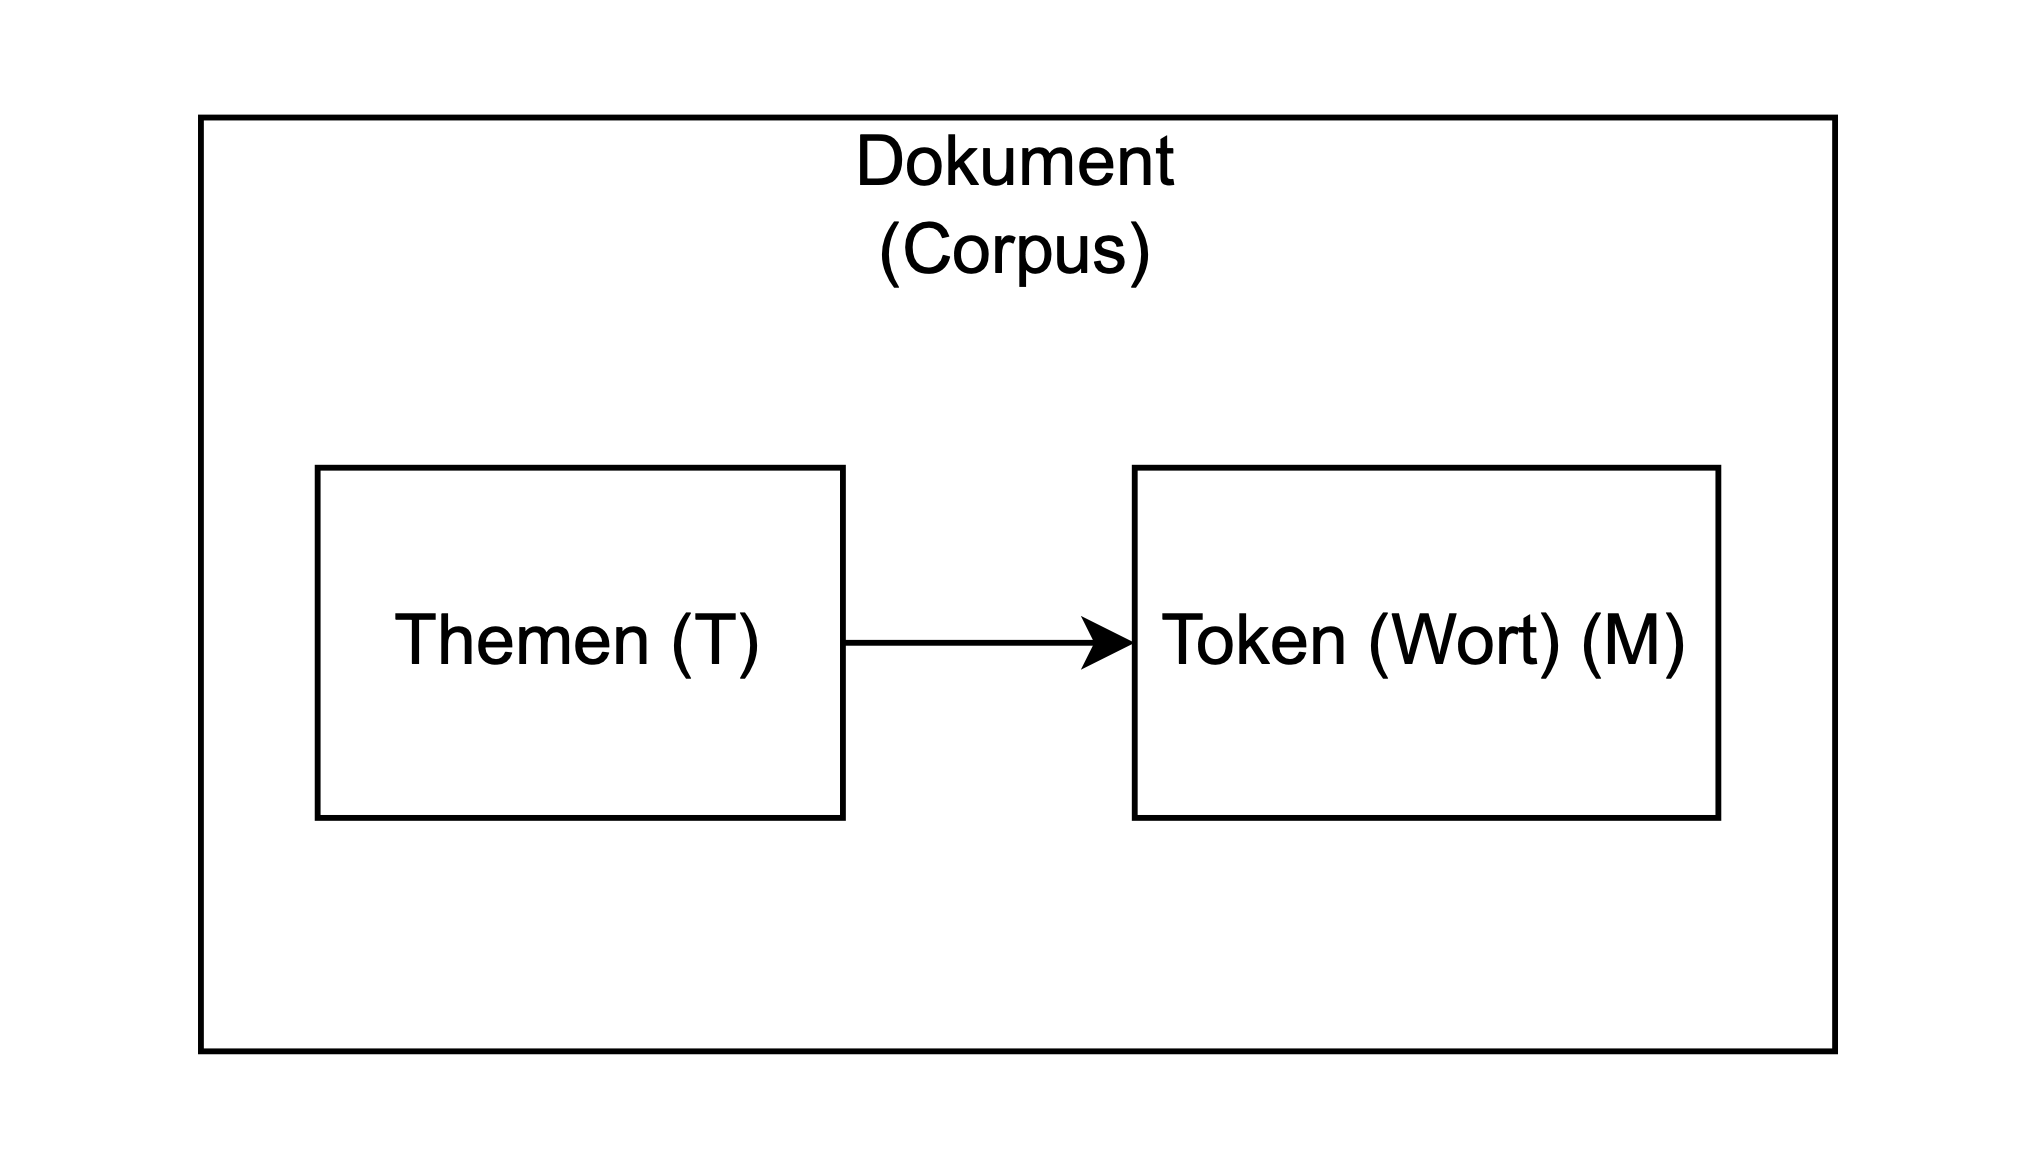


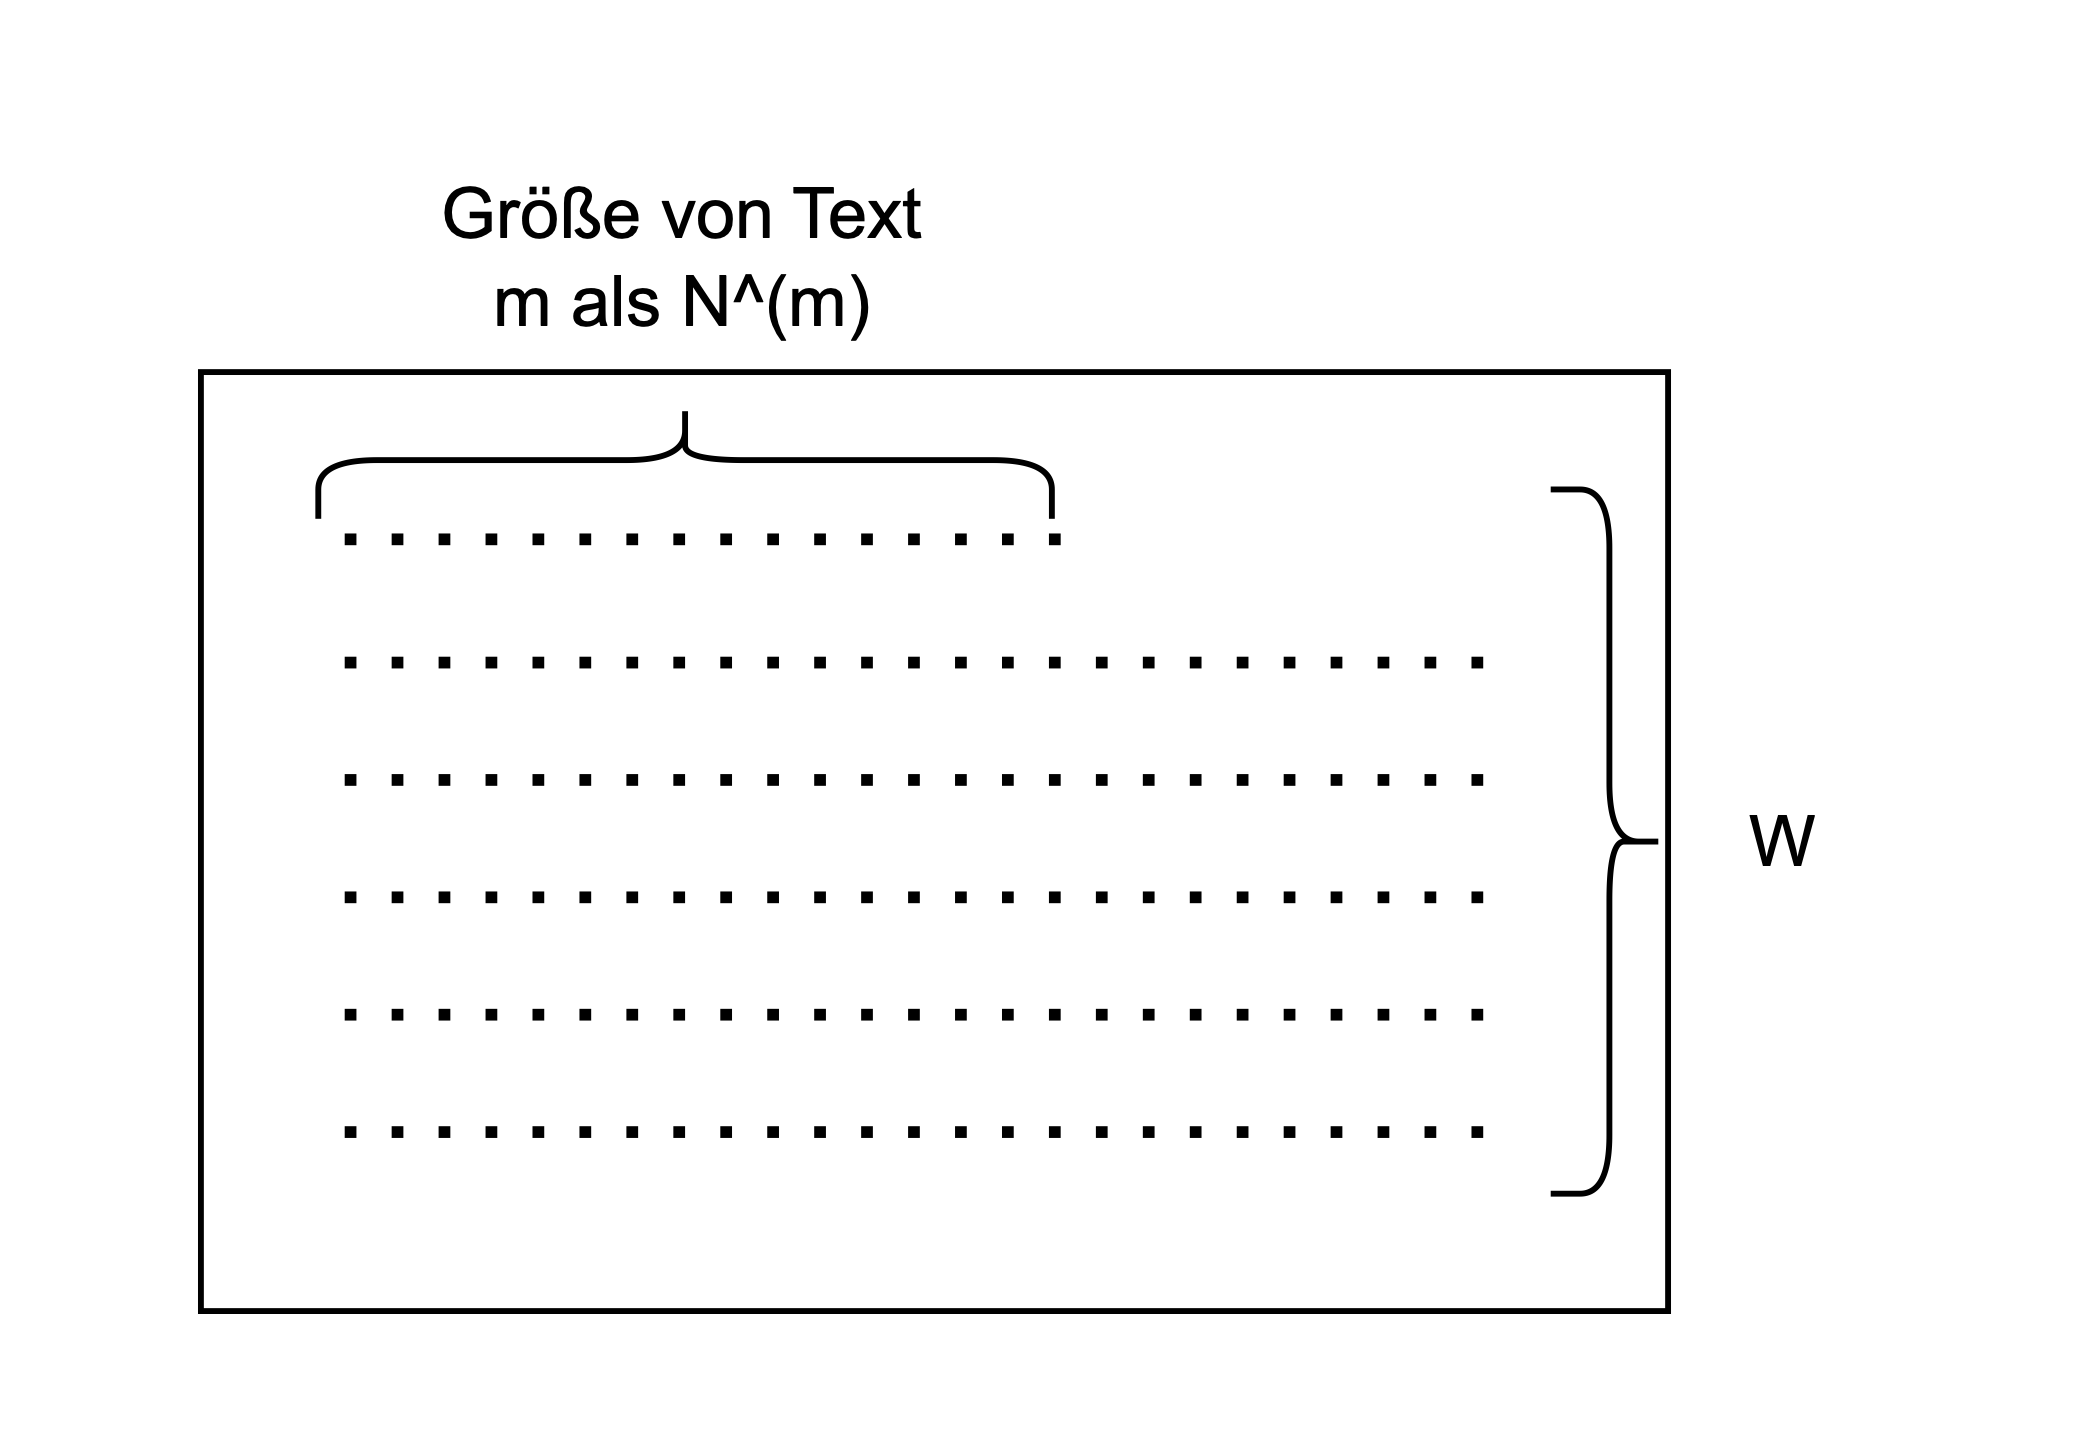

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

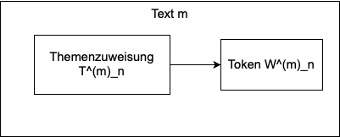

Um das Wahrscheinlichkeitsmodell für LDA aufzustellen sind folgende Definitionen und Annahmen notwendig: $n_k^((mv));k=1,…,K;v=1,…,V$ als Anzahl zugewiesener Wörter $v$ in Text $m$ zugehörig zu Thema $k$, dadurch lässt sich die Summe der Wörter $v$  in Thema $k$ über alle Dokumente $D$ mit $n_k^((*v))$ bestimmen. Wenn $w_k=(n_k^((*1)),…,n_k^((*V)) )^T$ die Vektoren der Wortanzahl für $k=1,…,K$ Themen ist, dann lässt sich mit diesen Definitionen das Modell wie folgt aufstellen:

$W_n^((m)) |T_n^((m)),ϕ_k  ~$ Discrete $(ϕ_k),		ϕ_k  ~$ Dirichlet $(η)$

$T_n^((m)) |θ_m  ~$ Discrete $(θ_m),		θ_m  ~$ Dirichlet $(α)$

Die Dirichlet Verteilungs Hyperparameter $α$ und $η$ müssen vom Nutzer deklariert werden. Da normalerweise keine a-priori (Anfangswahrscheinlichkeit) Informationen der Themen $θ$  und Wortverteilungen $ϕ$ vorliegen, werden $α$ und $η$ symmetrisch bestimmt (Rieger at al. (2020 Juni), S. 120).

Ein hoher $η$ Wert führt zu einem Verlust der Gleichmäßigkeit der Wortmischung pro Thema, ein niedriger $η$ Wert erhöht und verbessert die Gleichmäßigkeit wodurch weniger dominantere Wörter pro Thema zugeordnet werden. Nach dem gleichen Prinzip steuert α die Mischung der Themen in den Texten (Rieger at al. (2020 Juni), S. 120).

LDA ist eine Weiterentwicklung von LSI, bzw. pLSI, wobei LSI selbst eine Weiterentwicklung von tf-idf ist (Blei et al. (2003), S. 994). LSI verbessert tf-idf indem eine größere reduktion der Beschreibungslänge in großen Daten möglich ist und die statistische Struktur zwischen oder innerhalb von Dokumenten offenbart (Blei et al. (2003), S. 994; Rosario, B. (2000)). Probability LSI (pLSI) verbessert LSI dahingehend, dass alle Worte in einem Dokument eine Stichprobe aus einem Mischungsmodell sind in welchem wiederum verschiedene Themen Multinomial-Verteilungen abgebildet sind (Blei et al. (2003), S. 994). Durch die linearität des Modelles kommt es zu overfitting, zusätzlich gibt es keine Möglichkeit nicht im Training enthaltenen Dokumenten eine Wahrscheinlichkeit zuzuweisen (Blei et al. (2003), S. 994).
Um Repräsentationen von Dokumenten und Wörtern austauschbar abzubilden, ist es notwendig mixture-models zu verwenden und somit den angeführten Limitationen von LSI und verwandten Ansätzen zu entgehen (Blei et al. (2003), S. 995).

Außerdem grenzt sich LDA von Hierarchical Latent Tree Analysis (HLTA) wie folgt ab, HLTA stellt Koinzidenz Muster explizit in Modellstrukturen dar (Chen at al. (2017), S. 1). HLTA ist somit eine Methode um Themen zu erkennen, indem ein Thema anhand von Wörtern identifiziert wird, die häufig in einem Thema und selten in einem anderen Thema auftreten (Liu et al. (2014), S. 1).

Somit besteht ein $**Dokument**$ aus:
$$D^((m))=(W_1^((m) ),…,W_(N^((m) ))^((m) ) ); m=1,…,M;W_n^((m) )∈W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

Somit besteht ein **$Dokument$** aus:
$$D^m=(W_1^m,…,W_N^m); m=1,…,M;W_n^m ∈ W;n=1,…,N^m$$
Die Themenzuweisung für einen Text $m$ ist wie folgt:
$$T^((m) )=(T^((m)),…,T_(N^((m)))^((m)) ),T_n^((m))∈T$$
Jede Themenzuweisung $T_n^((m))$ hängt mit einem Token $W_n^((m))$ aus dem Text $m$ zusammen.

In [135]:
import time
start_time = time.time()
lda_model = LdaModel(corpus=corpus, id2word=id2word,
                    num_topics=unique_categories,
                    random_state=42,
                    passes=20,
                    alpha="auto",
                    per_word_topics=True)
stop_time = time.time()
run_time = stop_time - start_time
print("Wall time:", run_time/60, "m")

Wall time: 6.824345616499583 m


In [136]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence="c_v")
coherence_lda = coherence_model_lda.get_coherence()
print("Coherence Score:", coherence_lda)

Coherence Score: 0.24726929514776436


In [137]:
data = {
    "Duration (minutes)": [run_time/60],
    "Coherence Score": [coherence_lda]
}
export_df = pd.DataFrame(data)
export_df.insert(0, 'Run', 1)
export_df.to_csv(r"data\vanilla_lda_data.csv", index=False)
#export_df.to_csv('data/vanilla_lda_data.csv', index=False) # mac code
export_df.head()

,Run,Duration (minutes),Coherence Score
0,1,6.824346,0.247269


# Step 4: Visualisierung mit pyLDAvis
Um zu visualisieren, wie unser LDA Model Wörter kategorisiert, nutzen wir die Library pyLDAvis.
<br>Mit ihr können wir uns einen interaktiven und intuitiven Überblick über unser Model verschaffen

In [138]:
import pyLDAvis
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()

In [139]:
visualisation = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

In [140]:
visualisation

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
11    -0.391766 -0.270957       1        1  19.004644
21    -0.185465  0.369834       2        1   5.797611
20    -0.126560  0.122186       3        1   4.283900
14    -0.053542  0.031112       4        1   3.078349
9     -0.039842  0.021300       5        1   3.009232
18    -0.074100  0.048721       6        1   2.624779
2     -0.029564  0.014858       7        1   2.521899
30     0.050003 -0.018190       8        1   2.504977
26     0.018624 -0.008056       9        1   2.467865
19    -0.001338  0.000189      10        1   2.339674
22    -0.015209  0.007018      11        1   2.323689
7      0.000347 -0.000559      12        1   2.244372
13     0.041821 -0.015908      13        1   2.222906
8     -0.004137  0.001538      14        1   2.197659
24     0.009705 -0.004579      15        1   2.181055
4      0.003063 -0.001691      16        1   2.144281
34     0.013738 -0.006062      17        1   2.137317
28     0.013972 -0.006211      18        1   2.085394
3     -0.000674 -0.000069      19        1   2.039870
10     0.012039 -0.005399      20        1   2.015069
36     0.070216 -0.023408      21        1   1.988296
16     0.034639 -0.013600      22        1   1.983678
32     0.024670 -0.010194      23        1   1.969360
6      0.032983 -0.013087      24        1   1.941027
27     0.035604 -0.013863      25        1   1.938905
1      0.025824 -0.010651      26        1   1.929996
35     0.034893 -0.013644      27        1   1.909596
25     0.062454 -0.021536      28        1   1.850857
17     0.041195 -0.015612      29        1   1.833883
5      0.030684 -0.012226      30        1   1.802268
29     0.047667 -0.017551      31        1   1.767460
12     0.044516 -0.016680      32        1   1.755103
15     0.060975 -0.021199      33        1   1.731127
31     0.045514 -0.016872      34        1   1.683646
33     0.041833 -0.015839      35        1   1.638966
23     0.060608 -0.021020      36        1   1.584662
0      0.064610 -0.022096      37        1   1.466630, topic_info=         Term          Freq         Total Category  logprob  loglift
1564    photo  31292.000000  31292.000000  Default  30.0000  30.0000
145       day  22555.000000  22555.000000  Default  29.0000  29.0000
3310  wedding  10367.000000  10367.000000  Default  28.0000  28.0000
921      love  12019.000000  12019.000000  Default  27.0000  27.0000
104     world  10756.000000  10756.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
582     grand    491.116874    492.195110  Topic37  -4.6464   4.2200
7507   period    485.275765    486.354001  Topic37  -4.6584   4.2200
4103  whitney    467.887190    468.965426  Topic37  -4.6949   4.2199
174    aspect    448.632404    449.710640  Topic37  -4.7369   4.2198
2475  chronic    425.490187    426.568423  Topic37  -4.7899   4.2197

[1140 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
571      26  0.999328        1
212       2  0.999847       10
817      27  0.999139      100
590      12  0.999356       11
5244     11  0.999531       12
...     ...       ...      ...
2062     10  0.999556    youll
1575      3  0.999532    young
966       3  0.999817    youre
688      29  0.998920  youtube
7473      4  0.999684    youve

[1110 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 22, 21, 15, 10, 19, 3, 31, 27, 20, 23, 8, 14, 9, 25, 5, 35, 29, 4, 11, 37, 17, 33, 7, 28, 2, 36, 26, 18, 6, 30, 13, 16, 32, 34, 24, 1])

saving the pyldavis visual for later comparison in Benchmarks&Visualization (link)!

In [141]:
import pickle

In [142]:
with open('visuals/vanilla_lda.pkl', 'wb') as f:
    pickle.dump(visualisation, f)

# niklas hot fix

In [143]:
def assign_dominant_topic(lda_model, corpus):
    """
    Assigns the dominant topic to each document in the corpus based on the given LDA model.

    Parameters:
    lda_model (gensim.models.LdaModel): The LDA model used to infer topics.
    corpus (list of list of (int, int)): The corpus in Bag of Words (BOW) format.

    Returns:
    list: A list of dominant topics for each document in the corpus.
    """
    dominant_topics = []
    for bow in corpus:
        topic_probs = lda_model.get_document_topics(bow, minimum_probability=0)
        dominant_topic = sorted(topic_probs, key=lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

# Assign dominant topics and add the column to processed_df
dominant_topics = assign_dominant_topic(lda_model, corpus)
processed_df['dominant_topic'] = dominant_topics


/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_9400/2454338028.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['dominant_topic'] = dominant_topics


In [144]:
def map_topics_to_categories(processed_df):
    """
    Maps topics to the most common categories in the processed DataFrame.

    Parameters:
    processed_df (pandas.DataFrame): The DataFrame containing processed text and dominant topics.

    Returns:
    dict: A dictionary mapping each topic to the most common category among the documents assigned to that topic.
    """
    topic_category_mapping = {}
    for topic in processed_df['dominant_topic'].unique():
        # Get documents assigned to the topic
        topic_docs = processed_df[processed_df['dominant_topic'] == topic]
        # Find the most common category among these documents
        if not topic_docs.empty:
            most_common_category = topic_docs['category'].mode()[0]
            topic_category_mapping[topic] = most_common_category
    return topic_category_mapping

# Create the mapping
topic_category_mapping = map_topics_to_categories(processed_df)


In [145]:
def assign_predicted_category(processed_df, topic_category_mapping):
    """
    Assigns predicted categories to the processed DataFrame based on the dominant topic.

    Parameters:
    processed_df (pandas.DataFrame): The DataFrame containing processed text and dominant topics.
    topic_category_mapping (dict): A dictionary mapping each topic to the most common category among the documents assigned to that topic.

    Returns:
    pandas.DataFrame: The updated DataFrame with a new column 'predicted_category' containing the assigned categories.
    """
    processed_df['predicted_category'] = processed_df['dominant_topic'].map(topic_category_mapping)
    return processed_df

# Assign predicted categories
processed_df = assign_predicted_category(processed_df, topic_category_mapping)


/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_9400/600335101.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['predicted_category'] = processed_df['dominant_topic'].map(topic_category_mapping)


In [146]:
import pandas as pd

# Ensure the DataFrame `processed_df` has 'category' and 'predicted_category' columns
# Create a new column to indicate matches
processed_df['match'] = processed_df['category'] == processed_df['predicted_category']

# Group by category and count matches
match_counts = processed_df.groupby('category')['match'].sum().reset_index()
match_counts.columns = ['category', 'match_count']

# Count total entries per category
category_counts = processed_df['category'].value_counts(normalize=False).reset_index()
category_counts.columns = ['category', 'total_count']

# Merge match counts with total counts
comparison = pd.merge(match_counts, category_counts, on='category')

# Calculate match percentage
comparison['match_percentage'] = (comparison['match_count'] / comparison['total_count']) * 100

# Split into matched and no-match categories
matched_categories = comparison[comparison['match_count'] > 0]
no_match_categories = comparison[comparison['match_count'] == 0]

# Sort matched categories by match percentage (descending)
matched_categories_sorted = matched_categories.sort_values(by='match_percentage', ascending=False)

# Save the results as CSV
matched_categories_sorted.to_csv('data/vanilla-matched_categories.csv', index=False)
no_match_categories.to_csv('data/vanilla-no_match_categories.csv', index=False)

# Return or print the data
print(matched_categories_sorted)
print(no_match_categories)


          category  match_count  total_count  match_percentage
24        POLITICS        35585        35601         99.955057
6            CRIME           19         3562          0.533408
11     ENVIRONMENT            3         1444          0.207756
22       PARENTING            8         8791          0.091002
10   ENTERTAINMENT           10        17361          0.057600
30  STYLE & BEAUTY            3         9814          0.030569
8          DIVORCE            1         3426          0.029189
23         PARENTS            1         3955          0.025284
5           COMEDY            1         5398          0.018525
35        WELLNESS            3        17945          0.016718
3         BUSINESS            1         5991          0.016692
13    FOOD & DRINK            1         6340          0.015773
25    QUEER VOICES            1         6346          0.015758
          category  match_count  total_count  match_percentage
0             ARTS            0         1509           

/var/folders/3t/mgckmfnn5p745wd8_80ywb0c0000gn/T/ipykernel_9400/4129595927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_df['match'] = processed_df['category'] == processed_df['predicted_category']


In [147]:
# Prepare a DataFrame with the required columns
results_df = processed_df[['headline', 'short_description', 'category', 'predicted_category']]

# Save this DataFrame as CSV
results_df.to_csv('data/vanilla-predicted_categories.csv', index=False)

# Return or print the results
print(results_df.head(10))  # Show the first 10 rows for visual confirmation

                                             headline  \
2   23 Of The Funniest Tweets About Cats And Dogs ...   
3   The Funniest Tweets From Parents This Week (Se...   
8   How A New Documentary Captures The Complexity ...   
13  Twitch Bans Gambling Sites After Streamer Scam...   
16  'Reboot' Is A Clever And Not Too Navel-Gazey L...   
17  Maury Wills, Base-Stealing Shortstop For Dodge...   
20  Golden Globes Returning To NBC In January Afte...   
21  Biden Says U.S. Forces Would Defend Taiwan If ...   
24  ‘Beautiful And Sad At The Same Time’: Ukrainia...   
26  Las Vegas Aces Win First WNBA Title, Chelsea G...   

                                    short_description        category  \
2   "Until you have a dog you don't understand wha...          COMEDY   
3   "Accidentally put grown-up toothpaste on my to...       PARENTING   
8   In "Mija," director Isabel Castro combined mus...  CULTURE & ARTS   
13  One man's claims that he scammed people on the...            TECH   
16  Sta

# <a href="https://github.com/NiklasElsaesser/bug-free-fishstick/blob/main/Improved_LDA.ipynb">Improved_LDA</a>

# <a href="https://github.com/NiklasElsaesser/bug-free-fishstick/blob/main/Benchmarks%26Visualizations.ipynb">Benchmarks & Visualizations</a>

# Literaturhinweise
* Rosario, B. (2000). Latent semantic indexing: An overview. Techn. rep. INFOSYS, 240, 1-16.
* Chen, P., Zhang, N. L., Liu, T., Poon, L. K., Chen, Z., & Khawar, F. (2017). Latent tree models for hierarchical topic detection. Artificial Intelligence, 250, 105-124.
* Liu, T., Zhang, N. L., & Chen, P. (2014). Hierarchical latent tree analysis for topic detection. In Machine Learning and Knowledge Discovery in Databases: European Conference, ECML PKDD 2014, Nancy, France, September 15-19, 2014. Proceedings, Part II 14 (pp. 256-272). Springer Berlin Heidelberg.
* Rieger, J., Rahnenführer, J., & Jentsch, C. (2020, June). Improving latent Dirichlet allocation: On reliability of the novel method LDAPrototype. In International conference on applications of natural language to information systems (pp. 118-125). Cham: Springer International Publishing.
* Blei, D. M., Ng, A. Y., & Jordan, M. I. (2003). Latent dirichlet allocation. Journal of machine Learning research, 3(Jan), 993-1022.
* Schütze, H., Manning, C. D., & Raghavan, P. (2008). Introduction to information retrieval (Vol. 39, pp. 234-265). Cambridge: Cambridge University Press.
* Rieger, J., Koppers, L., Jentsch, C., Rahnenfu ̈hrer, J.: Improving Reliability of Latent Dirichlet Allocation by Assessing Its Stability Using Clustering Techniques on Replicated Runs (2020)
* Heyer, Gerhard, Wiedemann, Gregor, Niekler, Andreas (2020): Topic-Modelle und ihr Potenzial für die philologische Forschung, In Lobin, Henning, Schneider, Roman, Witt, Andreas (Hrsg.): Digitale Infrastrukturen für die germanistische Forschung (S.351-353), de Gruyter, 23.07.2018.
* Misra, Rishabh and Jigyasa Grover. "Sculpting Data for ML: The first act of Machine Learning." ISBN 9798585463570 (2021).